In [6]:
from cil.optimisation.functions import L2NormSquared, MixedL21Norm
from cil.optimisation.operators import DiagonalOperator, CompositionOperator,FiniteDifferenceOperator, IdentityOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cvxpy import *
from regularisers import dtv
import numpy as np
import matplotlib.pyplot as plt

# Load Data and resize

In [7]:
data = dataexample.CAMERA.get(size=(32, 32))

# Setup and run directional tv denoising with cvxpy

In [8]:
# Reference image
reference = data * 0.01

# Construct problem    
u_cvx = Variable(data.shape)

# fidelity
fidelity = sum_squares(u_cvx - data.array)   

# regulariser
eta = 0.1
alpha = 0.5
regulariser = alpha * dtv(u_cvx, reference, eta) 
constraints = []

obj =  Minimize( regulariser +  fidelity)
prob = Problem(obj, constraints)

# Choose solver (SCS is fast but less accurate than MOSEK)
res = prob.solve(verbose = True, solver = SCS, eps=1e-5)

                                     CVXPY                                     
                                    v1.1.17                                    
(CVXPY) Dec 06 08:01:03 PM: Your problem has 1024 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 06 08:01:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 08:01:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 08:01:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 08:01:03 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 06 08:01:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cvxpy/expressions/expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cvxpy/expressions/expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, Use

------------------------------------------------------------------
	       SCS v3.0.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 2049, constraints m: 4098
cones: 	  q: soc vars: 4098, qsize: 1025
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, warm_start: 0
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct
	  nnz(A): 7584, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.55e+01  1.01e+00  5.04e+03 -2.52e+03  1.00e-01  6.64e-03 
   250| 1.43e-02  8.10e-05  6.56e-02  2.90e+01  1.00e-01  1.11e-01 
   500| 4.79e-03  1.43e-04  2.47e-02  2.92e+01  1.00e-01  2.33e-01 
  

# Setup 2D directional TV denoising, using CIL and the PDHG algorithm

In [9]:
ig = data.geometry

# fidelity term
g = L2NormSquared(b=data)

# setup operator for directional TV
DY = FiniteDifferenceOperator(ig, direction=1)
DX = FiniteDifferenceOperator(ig, direction=0)

Grad = BlockOperator(DY, DX)
grad_ref = Grad.direct(reference)
denom = (eta**2 + grad_ref.pnorm(2)**2).sqrt()
xi = grad_ref/denom

A1 = DY - CompositionOperator(DiagonalOperator(xi[0]**2),DY) - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DX)
A2 = DX - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DY) - CompositionOperator(DiagonalOperator(xi[1]**2),DX)

operator = BlockOperator(A1, A2)

f = alpha * MixedL21Norm()

# use primal acceleration due to g being strongly convex
pdhg = PDHG(f = f, g = g, operator = operator, 
            max_iteration=500, update_objective_interval = 100, gamma_g = 1.)
pdhg.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    4.30843e+02  -0.00000e+00    4.30843e+02


/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cil/optimisation/algorithms/PDHG.py:358: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 1.0 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))
/opt/anaconda3/envs/cil_cvxpy/lib/python3.9/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.020    2.93090e+01   2.92706e+01    3.84407e-02
      200        500         0.020    2.92777e+01   2.92733e+01    4.38690e-03
      300        500         0.020    2.92747e+01   2.92733e+01    1.40190e-03
      400        500         0.020    2.92745e+01   2.92735e+01    1.02043e-03
      500        500         0.020    2.92737e+01   2.92735e+01    2.35558e-04
----------------------------------------------------------------------------
      500        500         0.020    2.92737e+01   2.92735e+01    2.35558e-04
Stop criterion has been reached.



# Compare solutions

CVX objective = 29.274418222513003
CIL objective = 29.27371597290039


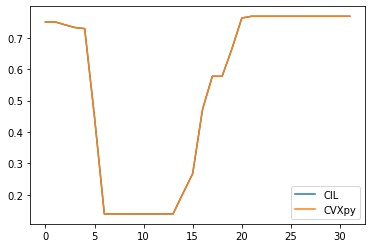

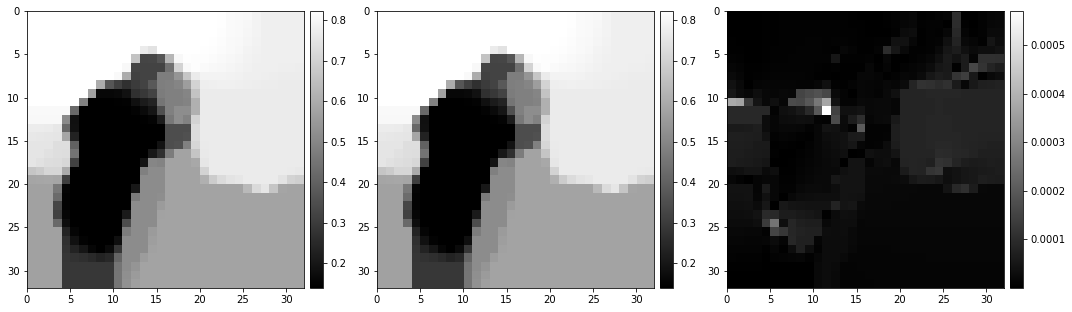

In [10]:
np.testing.assert_almost_equal(pdhg.solution.array, u_cvx.value, decimal=3)

# print objectives
print("CVX objective = {}".format(obj.value))

print("CIL objective = {}".format(pdhg.objective[-1]))

# show middle line profiles
N, M = data.shape
plt.figure()
plt.plot(pdhg.solution.array[int(N/2)], label="CIL")
plt.plot(u_cvx.value[int(N/2)], label="CVXpy")
plt.legend()
plt.show()

show2D([pdhg.solution.array, u_cvx.value, np.abs(pdhg.solution.array - u_cvx.value)], num_cols = 3, origin="upper")
